In [19]:
# Imports
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn import svm
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb

# Set display options
pd.set_option('display.max_columns', 100)

# Configuration parameters
RFC_METRIC = 'gini'
NUM_ESTIMATORS = 100
NO_JOBS = 4
VALID_SIZE = 0.20
TEST_SIZE = 0.20
NUMBER_KFOLDS = 5
RANDOM_STATE = 2018
MAX_ROUNDS = 1000
EARLY_STOP = 50
OPT_ROUNDS = 1000
VERBOSE_EVAL = 50

# Path to dataset
IS_LOCAL = True

if IS_LOCAL:
    PATH = r"C:\Users\bette\OneDrive\Desktop\BP"  # Local folder containing creditcard.csv
else:
    PATH = "../input"

# List files in the dataset directory
print("Files in dataset path:", os.listdir(PATH))

# Load the dataset
data_df = pd.read_csv(os.path.join(PATH, "creditcard.csv"))
print("Dataset loaded successfully. Shape:", df.shape)
data_df.head()


Files in dataset path: ['bitcoin.csv', 'Bitcoin_data.csv', 'creditcard.csv', 'data.csv', 'face Detec', 'project']
Dataset loaded successfully. Shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [20]:
# Check the first few rows of the dataset
print("\nFirst few rows of the dataset:")
print(data_df.head())

# Info about the dataset (types, non-null counts)
print("\nDataset Information:")
data_df.info()

# Check for missing values
print("\nMissing values in each column:")
print(data_df.isnull().sum())



First few rows of the dataset:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10       V11       V12       V13       V14  \
0  0.098698  0.363787  0.090794 -0.551600 -0.617801 -0.991390 -0.311169   
1  0.085102 -0.255425 -0.166974  1.612727  1.065235  0.489095 -0.143772   
2  0.247676 -1.514654  0.207643  0.624501  0.066084  0.717293 -0.165946   
3  0.377436 -1.387024 -0.054952 -0.226487  0.178228  0.507757 -0.287924   
4 -0.270533  0.817739  0.753074 -0.822843  0.538196  1.345852 -1.119670   

        V15       V16       V1

In [21]:
# Descriptive statistics of the dataset
print("\nDescriptive statistics of the dataset:")
print(data_df.describe())



Descriptive statistics of the dataset:
                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  3.918649e-15  5.682686e-16 -8.761736e-15  2.811118e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean  -1.552103e-15  2.040130e-15 -1.698953e-15 -1.893285e-16 -3.147640e-15   
st

In [22]:
# Check the distribution of the target variable
print("\nTarget variable distribution (fraud vs non-fraud):")
print(data_df['Class'].value_counts())



Target variable distribution (fraud vs non-fraud):
0    284315
1       492
Name: Class, dtype: int64


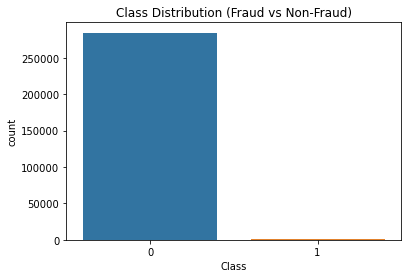

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the class distribution (fraud vs non-fraud)
sns.countplot(x='Class', data=data_df)
plt.title('Class Distribution (Fraud vs Non-Fraud)')
plt.show()


In [27]:
# Check for the class distribution
class_counts = data_df['Class'].value_counts()
print("\nClass distribution:")
print(class_counts)



Class distribution:
0    284315
1       492
Name: Class, dtype: int64


In [28]:
import plotly.figure_factory as ff
from plotly.offline import iplot

# Split 'Time' feature based on fraud class
class_0 = data_df.loc[data_df['Class'] == 0]["Time"]
class_1 = data_df.loc[data_df['Class'] == 1]["Time"]

# Create histogram data and labels for both classes
hist_data = [class_0, class_1]
group_labels = ['Not Fraud', 'Fraud']

# Create a density plot using Plotly
fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)
fig['layout'].update(title='Credit Card Transactions Time Density Plot', xaxis=dict(title='Time [s]'))

# Show the plot
iplot(fig, filename='dist_only')


In [29]:
# Create a new column 'Hour' which is the hour of the transaction
data_df['Hour'] = data_df['Time'].apply(lambda x: np.floor(x / 3600))

# Group by hour and class, and aggregate the transaction statistics
tmp = data_df.groupby(['Hour', 'Class'])['Amount'].aggregate(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index()

# Convert the aggregated data to a DataFrame
df = pd.DataFrame(tmp)

# Rename columns for easier readability
df.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']

# Display the first few rows
df.head()


,Hour,Class,Min,Max,Transactions,Sum,Mean,Median,Var
0,0.0,0,0.0,7712.43,3961,256572.87,64.774772,12.990,45615.821201
1,0.0,1,0.0,529.00,2,529.00,264.500000,264.500,139920.500000
2,1.0,0,0.0,1769.69,2215,145806.76,65.826980,22.820,20053.615770
3,1.0,1,59.0,239.93,2,298.93,149.465000,149.465,16367.832450
4,2.0,0,0.0,4002.88,1555,106989.39,68.803466,17.900,45355.430437


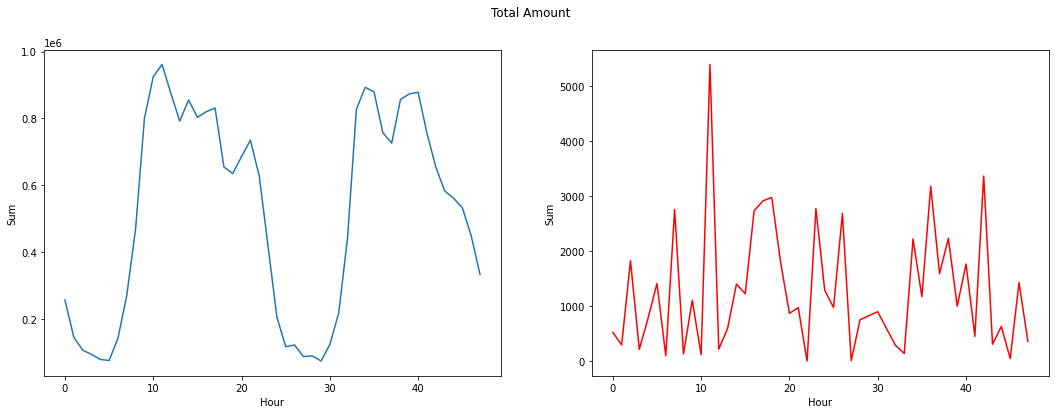

In [30]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Sum", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Sum", data=df.loc[df.Class==1], color="red")
plt.suptitle("Total Amount")
plt.show()


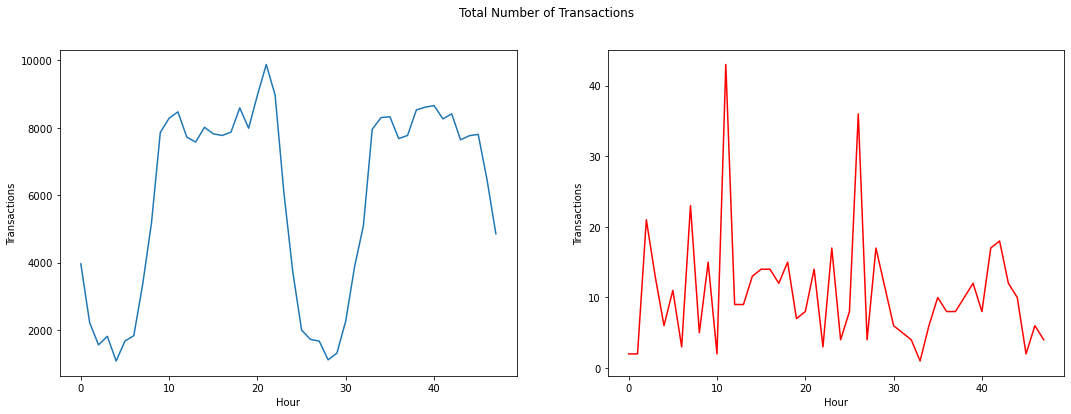

In [32]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Transactions", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Transactions", data=df.loc[df.Class==1], color="red")
plt.suptitle("Total Number of Transactions")
plt.show()


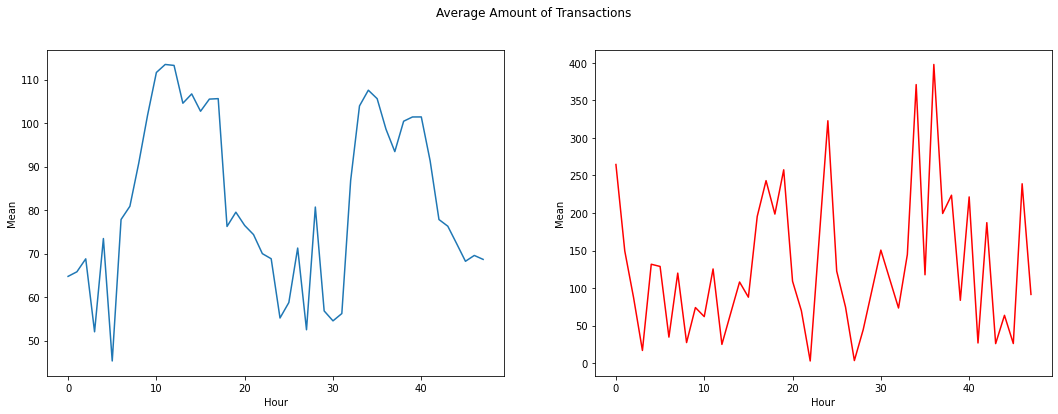

In [33]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Mean", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Mean", data=df.loc[df.Class==1], color="red")
plt.suptitle("Average Amount of Transactions")
plt.show()


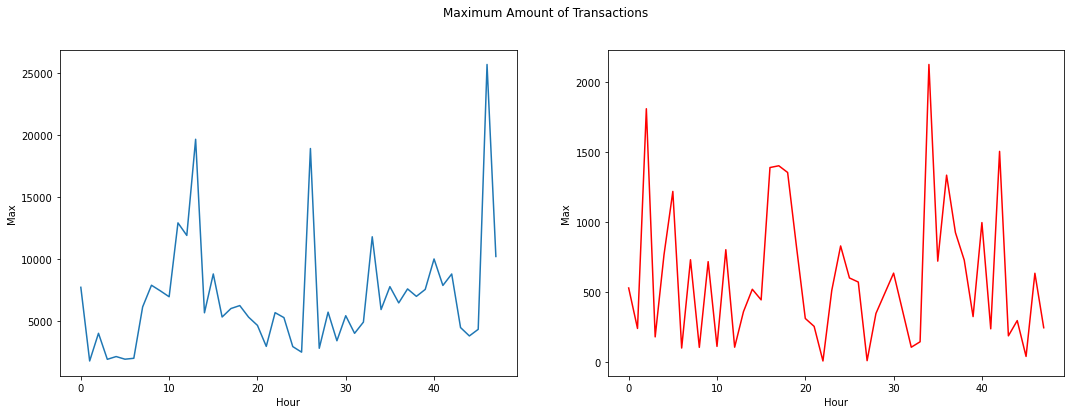

In [34]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Max", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Max", data=df.loc[df.Class==1], color="red")
plt.suptitle("Maximum Amount of Transactions")
plt.show()


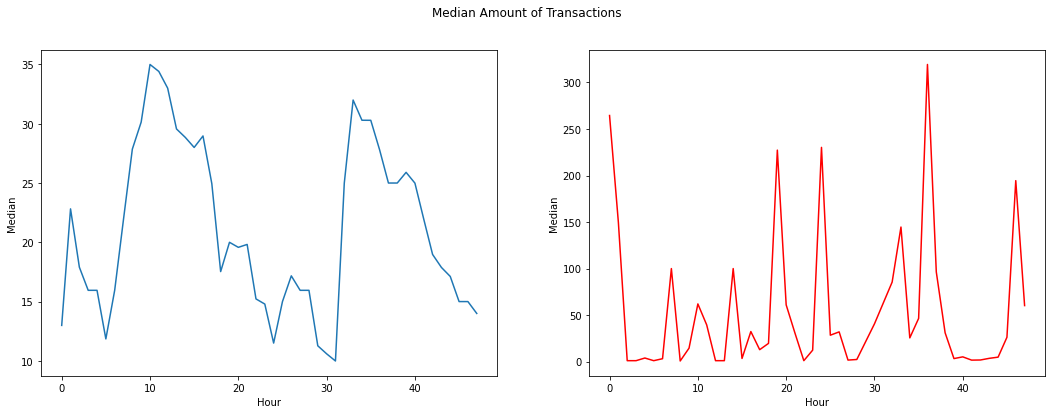

In [35]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Median", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Median", data=df.loc[df.Class==1], color="red")
plt.suptitle("Median Amount of Transactions")
plt.show()


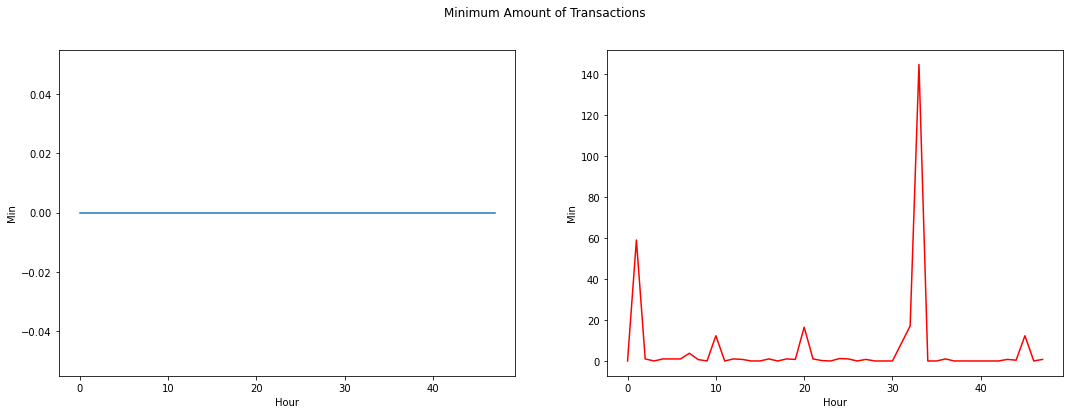

In [36]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Min", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Min", data=df.loc[df.Class==1], color="red")
plt.suptitle("Minimum Amount of Transactions")
plt.show()


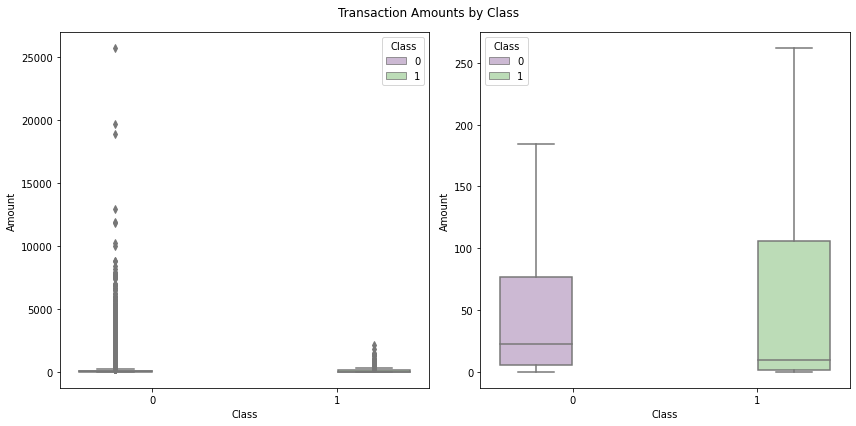

In [37]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
sns.boxplot(ax=ax1, x="Class", y="Amount", hue="Class", data=data_df, palette="PRGn", showfliers=True)
sns.boxplot(ax=ax2, x="Class", y="Amount", hue="Class", data=data_df, palette="PRGn", showfliers=False)
plt.suptitle("Transaction Amounts by Class")
plt.tight_layout()
plt.show()


In [38]:
class_0 = data_df.loc[data_df['Class'] == 0]['Amount']
class_1 = data_df.loc[data_df['Class'] == 1]['Amount']

print("Class 0 (Not Fraud):")
print(class_0.describe())
print("\nClass 1 (Fraud):")
print(class_1.describe())


Class 0 (Not Fraud):
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

Class 1 (Fraud):
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64


In [39]:
import plotly.graph_objs as go
from plotly.offline import iplot

fraud = data_df[data_df['Class'] == 1]

trace = go.Scatter(
    x=fraud['Time'],
    y=fraud['Amount'],
    mode="markers",
    name="Fraud Amount",
    marker=dict(color='red', line=dict(color='darkred', width=1), opacity=0.5),
    text=fraud['Amount']
)

layout = dict(
    title='Amount of Fraudulent Transactions Over Time',
    xaxis=dict(title='Time [s]', showticklabels=True),
    yaxis=dict(title='Amount'),
    hovermode='closest'
)

fig = dict(data=[trace], layout=layout)
iplot(fig, filename='fraud-amount')


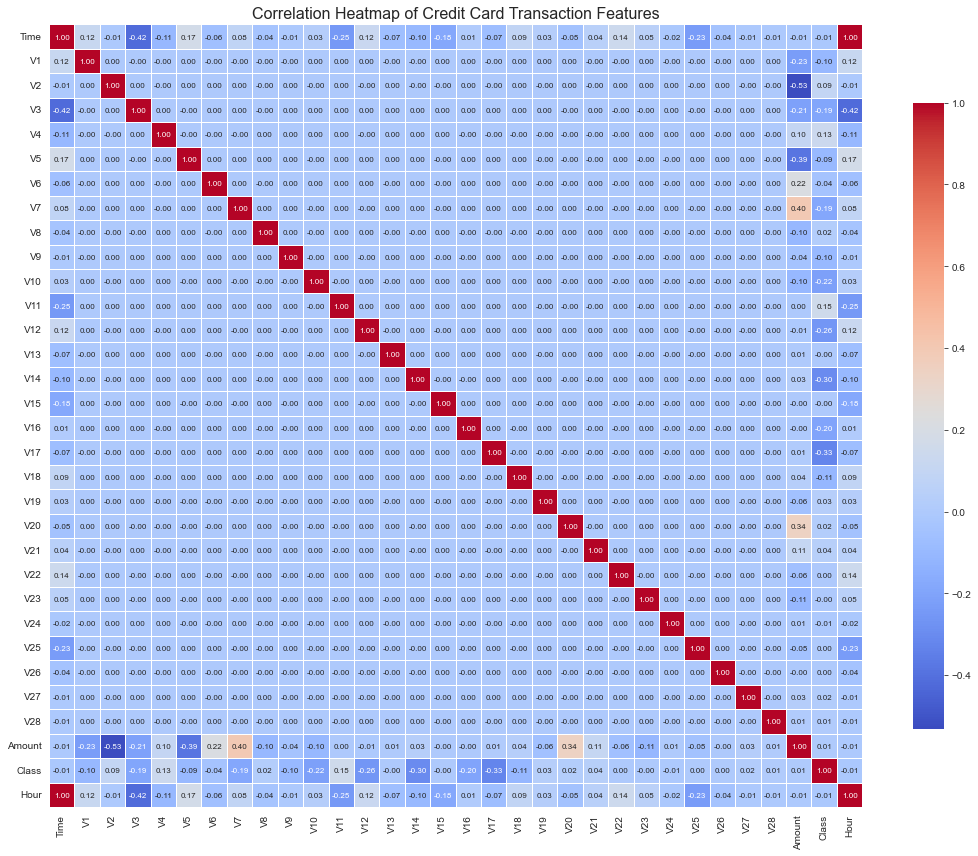

In [88]:
# Combined and cleaned-up correlation heatmap
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 12))
corr = data_df.corr()

sns.heatmap(
    corr,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    annot_kws={'size': 8},
    linewidths=0.5,
    linecolor='white',
    cbar_kws={'shrink': 0.8},
    xticklabels=corr.columns,
    yticklabels=corr.columns
)

plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("Correlation Heatmap of Credit Card Transaction Features", fontsize=16)
plt.tight_layout()
plt.show()



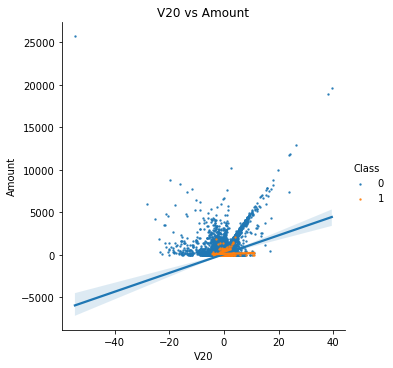

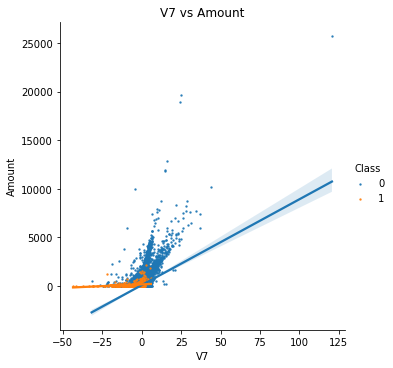

In [41]:
sns.lmplot(x='V20', y='Amount', data=data_df, hue='Class', fit_reg=True, scatter_kws={'s': 2})
plt.title("V20 vs Amount")

sns.lmplot(x='V7', y='Amount', data=data_df, hue='Class', fit_reg=True, scatter_kws={'s': 2})
plt.title("V7 vs Amount")
plt.show()


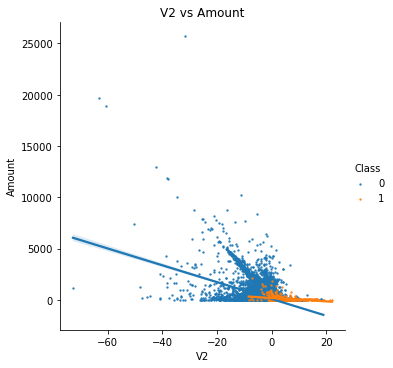

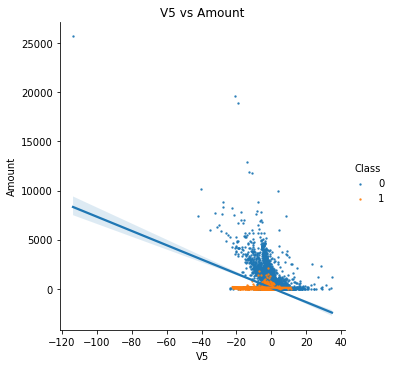

In [42]:
sns.lmplot(x='V2', y='Amount', data=data_df, hue='Class', fit_reg=True, scatter_kws={'s': 2})
plt.title("V2 vs Amount")

sns.lmplot(x='V5', y='Amount', data=data_df, hue='Class', fit_reg=True, scatter_kws={'s': 2})
plt.title("V5 vs Amount")
plt.show()


C:\Users\bette\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

C:\Users\bette\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 432x288 with 0 Axes>

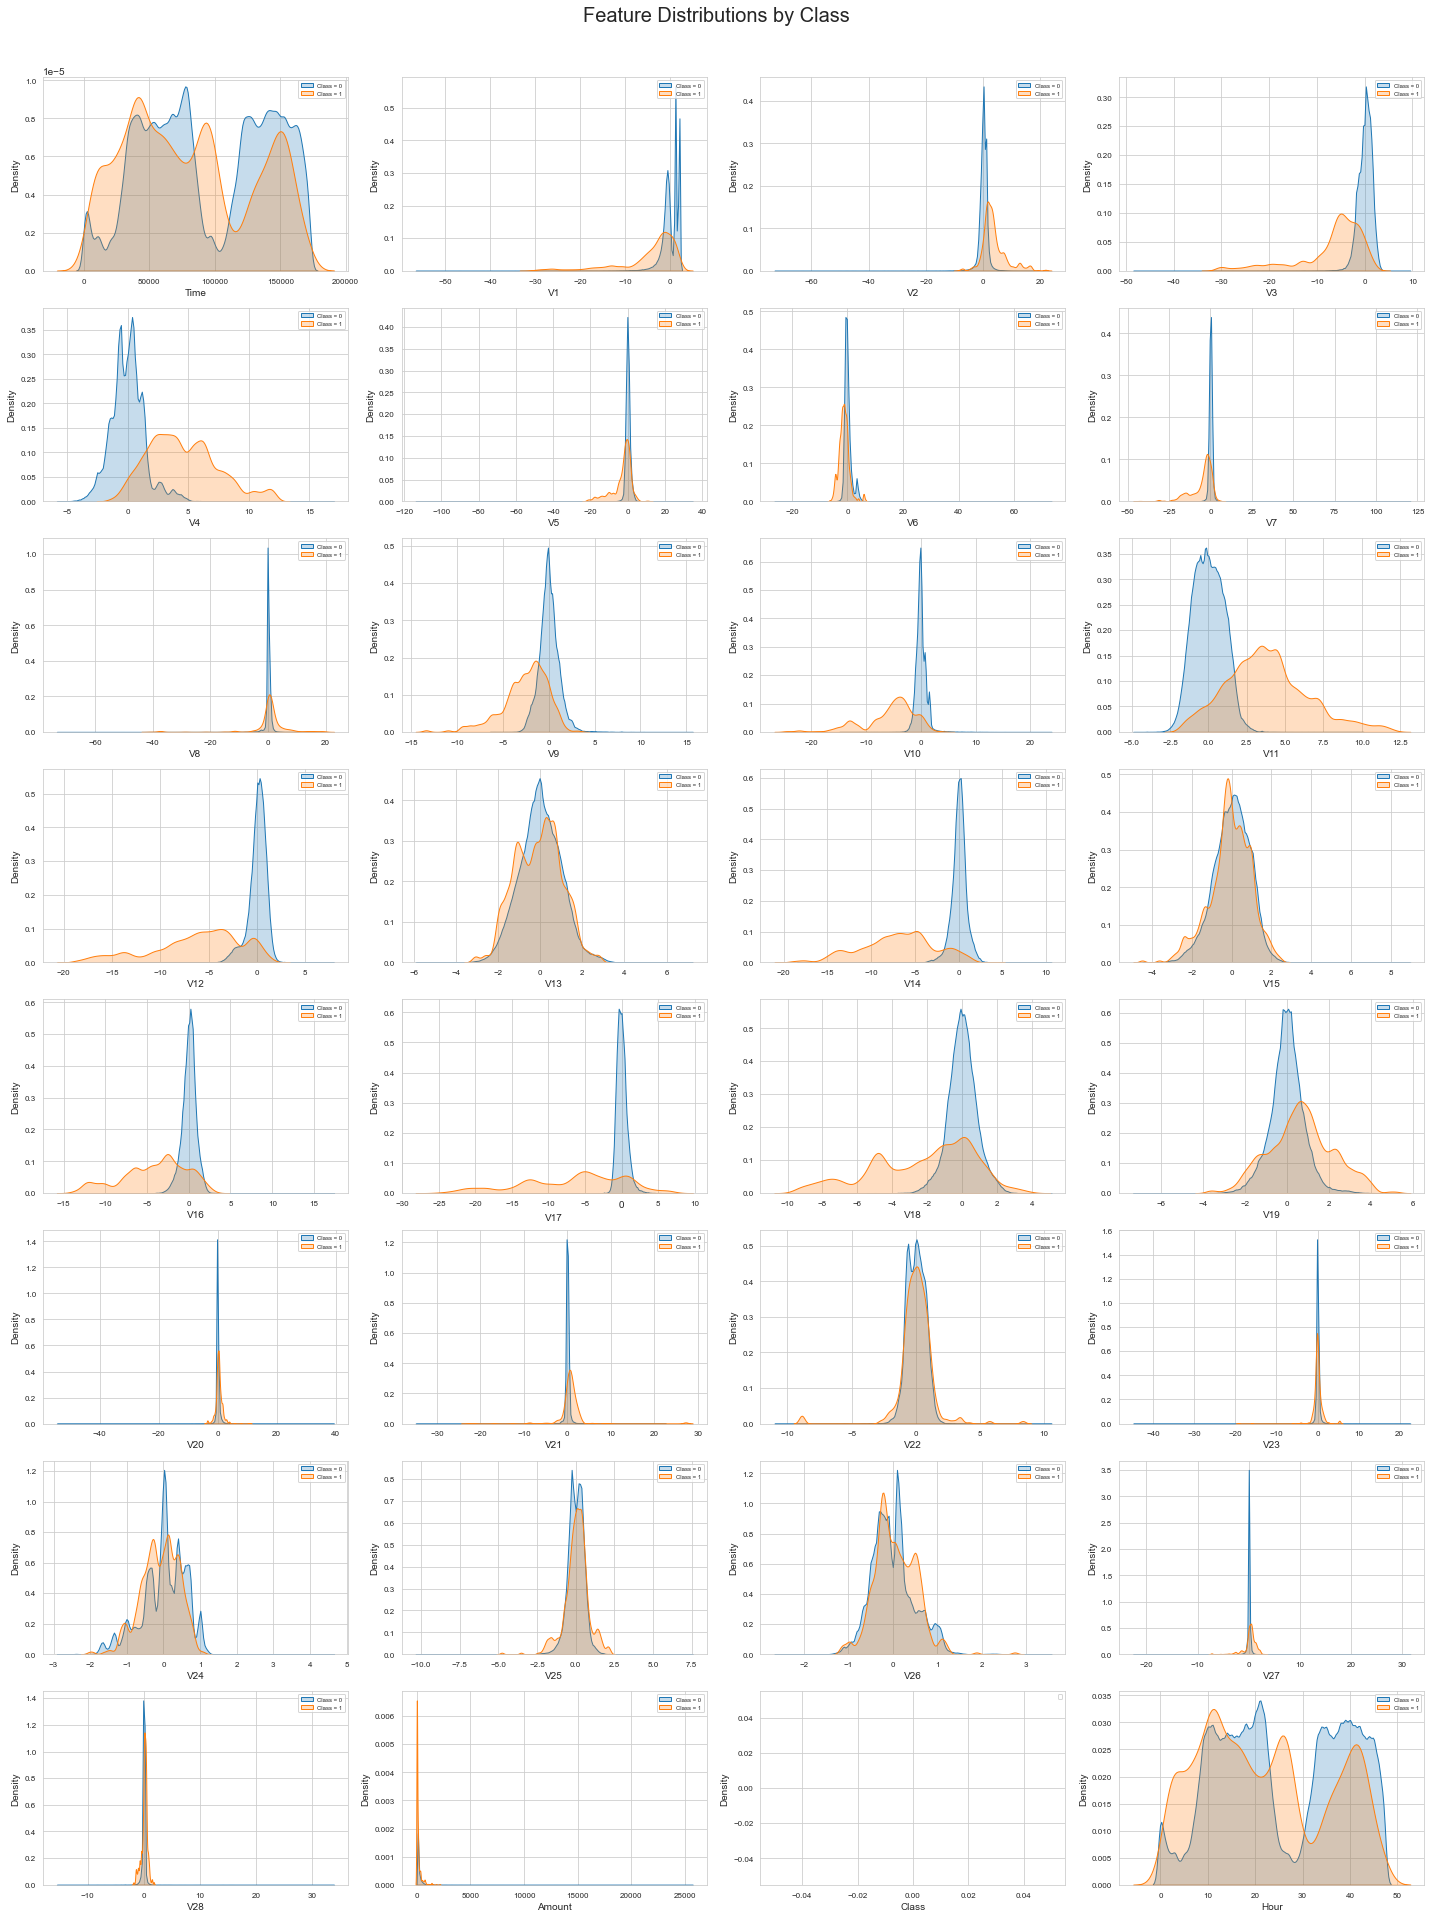

In [43]:
# List of all features
var = data_df.columns.values

# Split data by class
t0 = data_df[data_df['Class'] == 0]
t1 = data_df[data_df['Class'] == 1]

# Plotting setup
sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(8, 4, figsize=(20, 28))
fig.suptitle("Feature Distributions by Class", fontsize=20)

# Loop through each feature
for i, feature in enumerate(var):
    plt.subplot(8, 4, i + 1)
    sns.kdeplot(t0[feature], bw_adjust=0.5, label="Class = 0", fill=True)
    sns.kdeplot(t1[feature], bw_adjust=0.5, label="Class = 1", fill=True)
    plt.xlabel(feature, fontsize=10)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.legend(loc='upper right', fontsize=6)

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


In [44]:
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
              'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',
              'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',
              'Amount']


In [45]:
train_df, test_df = train_test_split(data_df, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True)
train_df, valid_df = train_test_split(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True)


In [46]:
clf = RandomForestClassifier(
    n_jobs=NO_JOBS,
    random_state=RANDOM_STATE,
    criterion=RFC_METRIC,
    n_estimators=NUM_ESTIMATORS,
    verbose=False
)

clf.fit(train_df[predictors], train_df[target].values)


RandomForestClassifier(n_jobs=4, random_state=2018, verbose=False)

In [47]:
preds = clf.predict(valid_df[predictors])


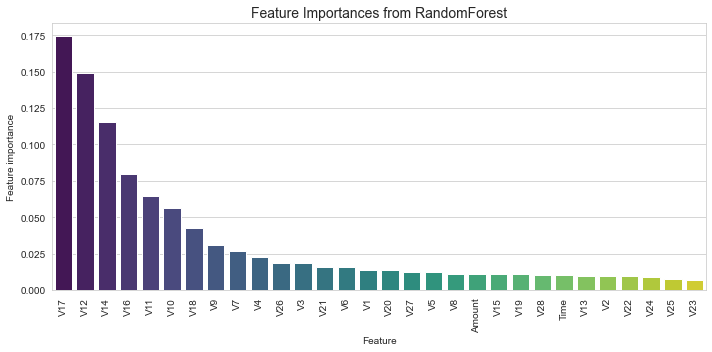

In [48]:
tmp = pd.DataFrame({
    'Feature': predictors,
    'Feature importance': clf.feature_importances_
}).sort_values(by='Feature importance', ascending=False)

plt.figure(figsize=(10, 5))
plt.title('Feature Importances from RandomForest', fontsize=14)
s = sns.barplot(x='Feature', y='Feature importance', data=tmp, palette='viridis')
s.set_xticklabels(s.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show()


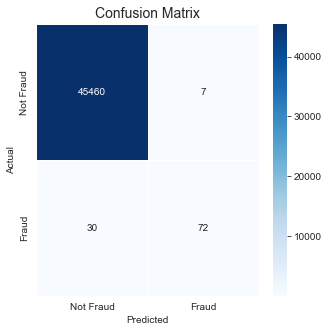

In [49]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])

plt.figure(figsize=(5, 5))
sns.heatmap(cm,
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,
            fmt='d',
            linewidths=0.5,
            cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()


In [50]:
from sklearn.metrics import roc_auc_score

# Calculate ROC-AUC Score
roc_auc_rf = roc_auc_score(valid_df[target].values, preds)
print(f"ROC-AUC Score (RandomForestClassifier): {roc_auc_rf:.4f}")


ROC-AUC Score (RandomForestClassifier): 0.8529


In [51]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(
    random_state=RANDOM_STATE,
    algorithm='SAMME.R',
    learning_rate=0.8,
    n_estimators=NUM_ESTIMATORS
)


In [52]:
clf.fit(train_df[predictors], train_df[target].values)


AdaBoostClassifier(learning_rate=0.8, n_estimators=100, random_state=2018)

In [53]:
preds = clf.predict(valid_df[predictors])


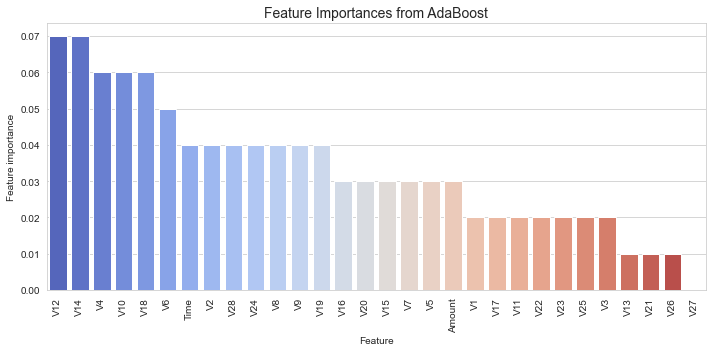

In [54]:
tmp = pd.DataFrame({
    'Feature': predictors,
    'Feature importance': clf.feature_importances_
}).sort_values(by='Feature importance', ascending=False)

plt.figure(figsize=(10, 5))
plt.title('Feature Importances from AdaBoost', fontsize=14)
s = sns.barplot(x='Feature', y='Feature importance', data=tmp, palette='coolwarm')
s.set_xticklabels(s.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show()


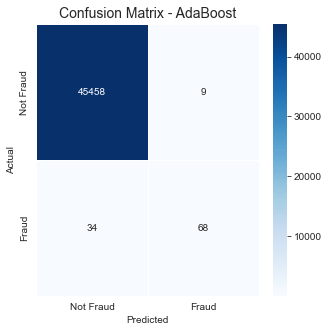

In [55]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])

plt.figure(figsize=(5, 5))
sns.heatmap(cm,
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,
            fmt='d',
            linewidths=0.5,
            cmap="Blues")
plt.title('Confusion Matrix - AdaBoost', fontsize=14)
plt.show()


In [56]:
roc_auc_ada = roc_auc_score(valid_df[target].values, preds)
print(f"ROC-AUC Score (AdaBoostClassifier): {roc_auc_ada:.4f}")


ROC-AUC Score (AdaBoostClassifier): 0.8332


In [57]:
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

clf = CatBoostClassifier(
    iterations=500,
    learning_rate=0.02,
    depth=12,
    eval_metric='AUC',
    random_seed=RANDOM_STATE,
    bagging_temperature=0.2,
    od_type='Iter',
    metric_period=VERBOSE_EVAL,
    od_wait=100,
    verbose=True
)


In [58]:
clf.fit(train_df[predictors], train_df[target].values)


0:	total: 806ms	remaining: 6m 42s
50:	total: 31.2s	remaining: 4m 34s
100:	total: 1m 1s	remaining: 4m 1s
150:	total: 1m 31s	remaining: 3m 30s
200:	total: 1m 57s	remaining: 2m 55s
250:	total: 2m 25s	remaining: 2m 24s
300:	total: 2m 54s	remaining: 1m 55s
350:	total: 3m 24s	remaining: 1m 27s
400:	total: 3m 52s	remaining: 57.3s
450:	total: 4m 19s	remaining: 28.2s
499:	total: 4m 47s	remaining: 0us


In [59]:
preds = clf.predict(valid_df[predictors])


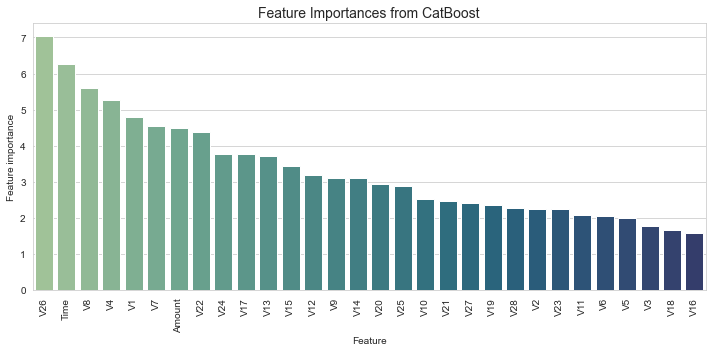

In [60]:
tmp = pd.DataFrame({
    'Feature': predictors,
    'Feature importance': clf.feature_importances_
}).sort_values(by='Feature importance', ascending=False)

plt.figure(figsize=(10, 5))
plt.title('Feature Importances from CatBoost', fontsize=14)
s = sns.barplot(x='Feature', y='Feature importance', data=tmp, palette='crest')
s.set_xticklabels(s.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show()


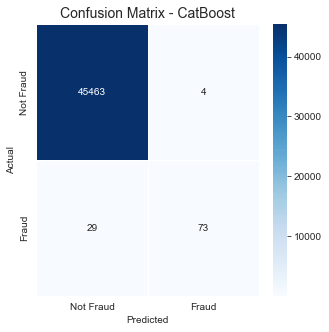

In [62]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])

plt.figure(figsize=(5, 5))
sns.heatmap(cm,
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,
            fmt='d',
            linewidths=0.5,
            cmap="Blues")
plt.title('Confusion Matrix - CatBoost', fontsize=14)
plt.show()


In [63]:
roc_auc_catboost = roc_auc_score(valid_df[target].values, preds)
print(f"ROC-AUC Score (CatBoostClassifier): {roc_auc_catboost:.4f}")


ROC-AUC Score (CatBoostClassifier): 0.8578


In [64]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# Prepare the DMatrix datasets
dtrain = xgb.DMatrix(train_df[predictors], label=train_df[target].values)
dvalid = xgb.DMatrix(valid_df[predictors], label=valid_df[target].values)
dtest = xgb.DMatrix(test_df[predictors], label=test_df[target].values)

# Watchlist to track performance on train and validation
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Set XGBoost parameters
params = {
    'objective': 'binary:logistic',
    'eta': 0.039,
    'max_depth': 2,
    'subsample': 0.8,
    'colsample_bytree': 0.9,
    'eval_metric': 'auc',
    'random_state': RANDOM_STATE,
    'verbosity': 1  # replaces deprecated 'silent' param
}


In [65]:
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=MAX_ROUNDS,
    evals=watchlist,
    early_stopping_rounds=EARLY_STOP,
    maximize=True,
    verbose_eval=VERBOSE_EVAL
)


[0]	train-auc:0.94070	valid-auc:0.88630
[50]	train-auc:0.94200	valid-auc:0.89009
[100]	train-auc:0.97584	valid-auc:0.96685
[150]	train-auc:0.98525	valid-auc:0.97960
[200]	train-auc:0.99279	valid-auc:0.98495
[250]	train-auc:0.99493	valid-auc:0.98352
[257]	train-auc:0.99511	valid-auc:0.98382


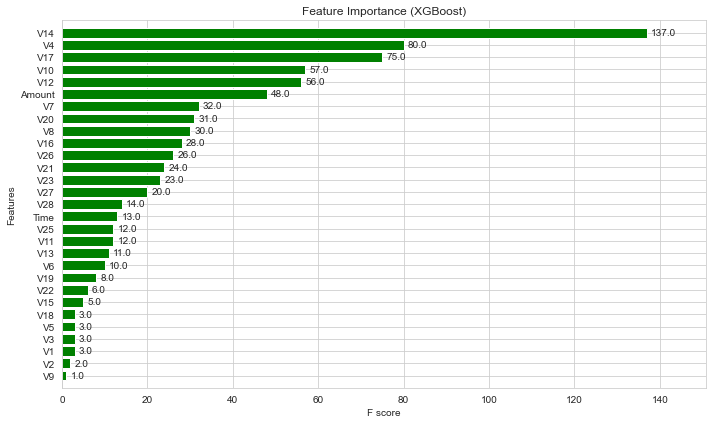

In [66]:
fig, ax = plt.subplots(figsize=(10, 6))
xgb.plot_importance(model, height=0.8, title="Feature Importance (XGBoost)", ax=ax, color="green")
plt.tight_layout()
plt.show()


In [67]:
preds = model.predict(dtest)


In [68]:
roc_auc = roc_auc_score(test_df[target].values, preds)
print(f"ROC-AUC Score (XGBoost on test set): {roc_auc:.4f}")


ROC-AUC Score (XGBoost on test set): 0.9803


In [69]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,
    'num_leaves': 7,
    'max_depth': 4,
    'min_child_samples': 100,
    'max_bin': 100,
    'subsample': 0.9,
    'subsample_freq': 1,
    'colsample_bytree': 0.7,
    'min_child_weight': 0,
    'min_split_gain': 0,
    'scale_pos_weight': 150,
    'nthread': 8,
    'verbose': 0
}


In [74]:
import lightgbm as lgb

# Prepare the datasets as LightGBM Dataset objects
dtrain = lgb.Dataset(train_df[predictors].values, 
                     label=train_df[target].values,
                     feature_name=predictors)

dvalid = lgb.Dataset(valid_df[predictors].values,
                     label=valid_df[target].values,
                     feature_name=predictors)

# Now train the model using LightGBM's Dataset objects
evals_results = {}

model = lgb.train(
    params,
    dtrain,
    valid_sets=[dtrain, dvalid],
    valid_names=['train', 'valid'],
    num_boost_round=MAX_ROUNDS,
    callbacks=[
        early_stopping(stopping_rounds=2*EARLY_STOP),
        log_evaluation(period=VERBOSE_EVAL)
    ]
)


Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.997909	valid's auc: 0.952288
[100]	train's auc: 0.999032	valid's auc: 0.945553
Early stopping, best iteration is:
[29]	train's auc: 0.996594	valid's auc: 0.957864


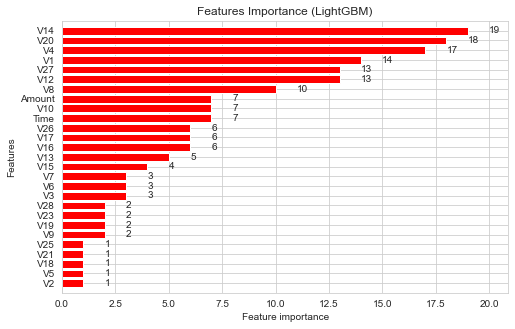

In [75]:
fig, ax = plt.subplots(figsize=(8, 5))
lgb.plot_importance(model, height=0.8, title="Features Importance (LightGBM)", ax=ax, color="red")
plt.show()


In [76]:
preds = model.predict(test_df[predictors])
roc_auc = roc_auc_score(test_df[target], preds)
print(f"ROC-AUC on test set: {roc_auc:.4f}")


ROC-AUC on test set: 0.9473


In [87]:
import numpy as np
from sklearn.metrics import roc_auc_score
import pandas as pd
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier
import gc

# Define cross-validation parameters
kf = KFold(n_splits=NUMBER_KFOLDS, random_state=RANDOM_STATE, shuffle=True)

oof_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()
n_fold = 0

# Loop over each fold in KFold
for train_idx, valid_idx in kf.split(train_df):
    train_x, train_y = train_df[predictors].iloc[train_idx], train_df[target].iloc[train_idx]
    valid_x, valid_y = train_df[predictors].iloc[valid_idx], train_df[target].iloc[valid_idx]

    model = LGBMClassifier(
        n_estimators=2000,
        learning_rate=0.01,
        num_leaves=31,  # Reduced from 80 to 31 to prevent overfitting
        max_depth=10,   # Limit the depth of trees
        colsample_bytree=0.98,
        subsample=0.78,
        reg_alpha=0.04,
        reg_lambda=0.073,
        subsample_for_bin=50,
        boosting_type='gbdt',
        is_unbalance=False,
        min_split_gain=0.1,  # Increased to require stronger splits
        min_child_weight=40,
        min_child_samples=510,
        objective='binary',
        metric='auc',
        silent=-1,
        min_data_in_leaf=20,  # Increased to avoid very small leaves
    )

    callbacks = [
        early_stopping(stopping_rounds=50),
        log_evaluation(period=50)
    ]

    model.fit(
        train_x, 
        train_y, 
        eval_set=[(train_x, train_y), (valid_x, valid_y)], 
        eval_metric='auc', 
        callbacks=callbacks
    )

    oof_preds[valid_idx] = model.predict_proba(valid_x, num_iteration=model.best_iteration_)[:, 1]
    test_preds += model.predict_proba(test_df[predictors], num_iteration=model.best_iteration_)[:, 1] / kf.n_splits

    fold_importance_df = pd.DataFrame({
        "feature": predictors,
        "importance": model.feature_importances_,
        "fold": n_fold + 1
    })
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    # Calculate the AUC for this fold
    fold_auc = roc_auc_score(valid_y, oof_preds[valid_idx])
    print(f"Fold {n_fold + 1} AUC : {fold_auc:.6f}")
    
    # Clear variables and collect memory
    del model, train_x, train_y, valid_x, valid_y
    gc.collect()
    n_fold += 1

# Final AUC score for out-of-fold predictions
full_auc = roc_auc_score(train_df[target], oof_preds)
print(f"Full OOF AUC score: {full_auc:.6f}")

# AUC score for the test data (average of all folds)
test_auc = roc_auc_score(test_df[target], test_preds)
print(f"The AUC score for the prediction from the test data was {test_auc:.6f}.")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=510 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=510 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=510 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [